# Importing libraries

In [1]:
import nltk
from nltk import FreqDist
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/asadimam/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
import pandas as pd
pd.set_option('display.max_colwidth',200)
import numpy as np
import re
import spacy
import gensim
from gensim import corpora
import json


In [6]:
# Libraries for visualisation

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/asadimam/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


# Reading data

In [7]:
df = pd.read_json('Automotive_5.json', lines=True)

In [8]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car and these had good reviews and were at a good price. They have been used a few times already and do what they are supposed to - no complaints there....,5,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011"
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but the quality seems a little on the shabby side. For the money I was not expecting 200 dollar snap-on jumper cables but these seem more like what you wo...",4,Okay long cables,1315094400,"09 4, 2011"
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]","Can't comment much on these since they have not yet been used (I will come back and update my review is I find any issues after first use) ... but they are built solid, nice tough big hard clamps ...",5,Looks and feels heavy Duty,1374710400,"07 25, 2013"
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]","I absolutley love Amazon!!! For the price of a set of cheap Booster/Jumper Cables in a brick and morter store, you can buy extra long and heavy duty jumpers! First off, don't be the person that ...",5,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010"
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]","I purchased the 12' feet long cable set and they arrived in a retail cardboard box with handle, which could be used as a storage and carrying case for these cables, although I will not need to sto...",5,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012"


# Data(Text) preprocessing 

In this step, we will remove the punctuations, stopwords and normalize the reviews as much as possible. After every preprocessing step, it is a good practice to check the most frequent words in the data.

In [9]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

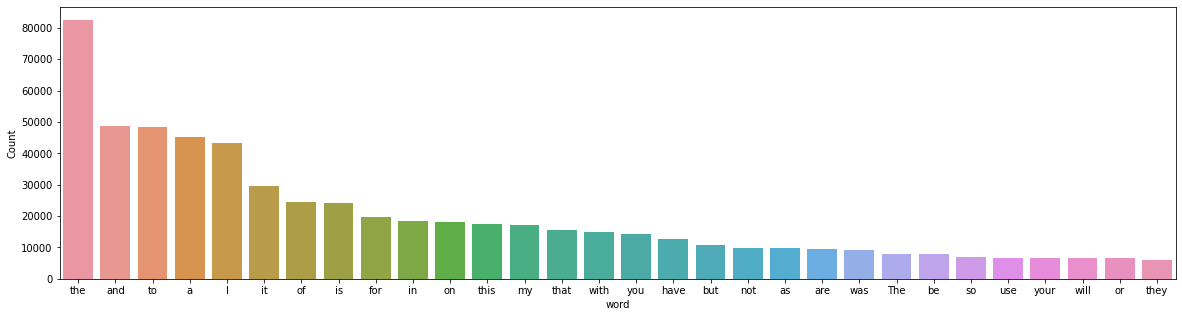

In [10]:
freq_words(df['reviewText'])


 - Looking at the data above it's clear that the most commonly used words are 'the','and','to' and so forth.
 - Such words provide no context so need to remove these
 - It's good practise to keep checking after every step of pre-processing

## Removing punctuations

We also need to remove punctuations

In [11]:
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

## Removing stopwords

In [12]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


In [13]:
stop_words[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [14]:
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new


In [15]:
# remove short words (length < 3)
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [16]:
# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['reviewText']]

In [17]:
# make entire text lowercase
reviews = [r.lower() for r in reviews]

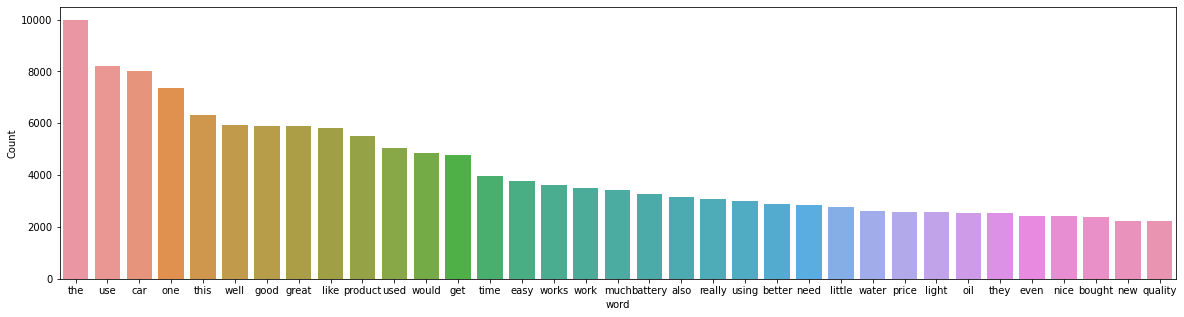

In [18]:
freq_words(reviews, 35)


 - We can see the more context words like 'car', 'batter', 'oil' have now become the most frequently appear words.
 - However words such 'the', 'this','they' still appear

## Lemmatisation

The process of reducing any given word to its base form thereby reducing multiple forms of a word to a single word

In [25]:
!python -m spacy download en

     |████████████████████████████████| 12.1MB 4.0MB/s eta 0:00:01    |████████████████████████▋       | 9.3MB 578kB/s eta 0:00:05
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-cp37-none-any.whl size=12047110 sha256=49280b0411e8e0cf4e5026cd3ae509f0f9dd4bce68b8221c558927cb6f6b1465
  Stored in directory: /private/var/folders/fp/r599qgn51yx03grg19j778fc0000gp/T/pip-ephem-wheel-cache-4_4fcuep/wheels/2b/3f/41/f0b92863355c3ba34bb32b37d8a0c662959da0058202094f46
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/asadimam/opt/anaconda3/lib/python3.7/site-packages/en_core_web_sm -->
/Users/asadimam/opt/anaconda3/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [26]:
nlp = spacy.load('en', disable=['parser', 'ner'])


In [27]:
def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

## Tokenise reviews and then lemmatise the tokenised review

In [28]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['these', 'long', 'cables', 'work', 'fine', 'truck', 'quality', 'seems', 'little', 'shabby', 'side', 'for', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cables', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'bucks']


In [29]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['long', 'cable', 'fine', 'truck', 'quality', 'little', 'shabby', 'side', 'money', 'expecting', 'dollar', 'cable', 'chinese', 'shop', 'harbor', 'freight', 'buck']


### We have not just lemmatized the words but also filtered only nouns and adjectives. Let’s de-tokenize the lemmatized reviews and plot the most common words.

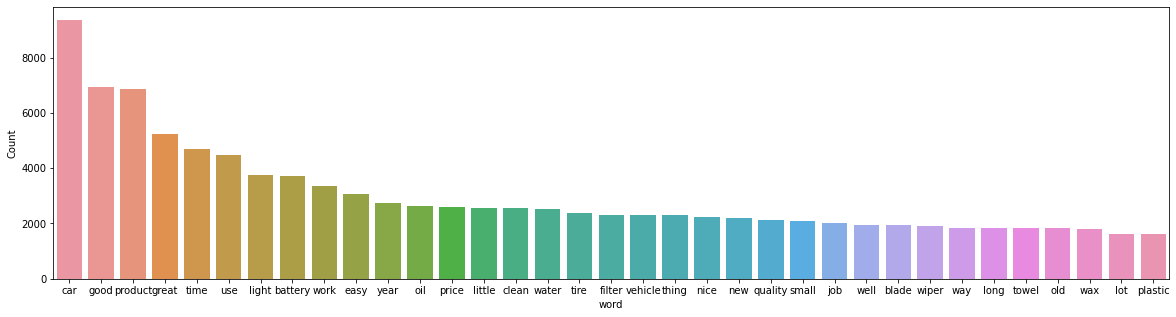

In [30]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 35)

# Building the LDA model

We will start by creating the term dictionary of our corpus, where every unique term is assigned an index



In [31]:
dictionary = corpora.Dictionary(reviews_2)


Then we will convert the list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.



In [32]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]


### Creating the object for LDA model using gensim library


In [33]:
LDA = gensim.models.ldamodel.LdaModel


In [34]:
# Build LDA model

In [35]:
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [36]:
lda_model.print_topics()


[(0,
  '0.047*"battery" + 0.033*"car" + 0.024*"power" + 0.019*"device" + 0.019*"unit" + 0.015*"plug" + 0.013*"phone" + 0.012*"use" + 0.012*"charger" + 0.012*"light"'),
 (1,
  '0.060*"tire" + 0.035*"hose" + 0.033*"wheel" + 0.033*"water" + 0.028*"pressure" + 0.023*"gauge" + 0.017*"air" + 0.014*"tank" + 0.014*"valve" + 0.011*"tape"'),
 (2,
  '0.045*"car" + 0.034*"product" + 0.022*"towel" + 0.020*"good" + 0.018*"clean" + 0.014*"great" + 0.013*"use" + 0.013*"water" + 0.013*"wax" + 0.012*"leather"'),
 (3,
  '0.017*"good" + 0.015*"blade" + 0.014*"wiper" + 0.013*"great" + 0.011*"easy" + 0.011*"time" + 0.011*"work" + 0.009*"thing" + 0.009*"product" + 0.008*"side"'),
 (4,
  '0.102*"light" + 0.042*"bulb" + 0.030*"bright" + 0.015*"headlight" + 0.015*"color" + 0.014*"white" + 0.014*"inverter" + 0.012*"mat" + 0.012*"kit" + 0.011*"night"'),
 (5,
  '0.035*"tool" + 0.023*"seat" + 0.022*"brush" + 0.016*"hand" + 0.015*"chemical" + 0.013*"grease" + 0.013*"glove" + 0.008*"polisher" + 0.007*"kid" + 0.007*"s

# Topics visualisation

In [37]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

/Users/asadimam/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.103057  0.044642       1        1  30.788410
2     -0.128198  0.044337       2        1  24.833488
0     -0.106117  0.053139       3        1  12.439408
6     -0.125852  0.022326       4        1  11.938789
4     -0.076856 -0.052883       5        1   7.435883
1      0.190006 -0.335626       6        1   7.234111
5      0.350075  0.224066       7        1   5.329905, topic_info=    Category         Freq     Term        Total  loglift  logprob
136  Default  4415.000000    light  4415.000000  30.0000  30.0000
36   Default  2863.000000  battery  2863.000000  29.0000  29.0000
304  Default  2112.000000     tire  2112.000000  28.0000  28.0000
2    Default  9437.000000      car  9437.000000  27.0000  27.0000
487  Default  2695.000000    water  2695.000000  26.0000  26.0000
..       ...          ...      ...          ...      ...      ...
47    Topic7   170.786102     hard   778.144043   1.4153  -5.0205
268   Topic7   144.499207      guy   395.110352   1.9259  -5.1876
62    Topic7   168.671356    small  2091.795898   0.4140  -5.0329
107   Topic7   137.031250   enough  1076.959595   0.8701  -5.2407
262   Topic7   120.708290   driver   653.969299   1.2422  -5.3675

[401 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1519      4  0.993600  acceleration
1903      1  0.292815      adhesive
1903      7  0.705231      adhesive
473       4  0.421071           air
473       6  0.578373           air
...     ...       ...           ...
248       4  0.181925          year
248       5  0.037937          year
1407      2  0.203524        yellow
1407      3  0.031311        yellow
1407      5  0.763216        yellow

[602 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 7, 5, 2, 6])